In [1]:
from matplotlib import pyplot as plt
import matplotlib
from sklearn import preprocessing
import os
import numpy as np
import random as rd
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
sess  = tf.compat.v1.InteractiveSession()
from scipy.integrate import odeint
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import joblib

In [2]:
def discrete_toggle_switch(x):
    V1, V2, b1, b2, n, delta = np.array([5, 5, 1, 2, 2, 0.18])
    dt = 0.2
    x_f1 = (1 - delta*dt)*x[0] + V1*dt/(1 + b1*x[1]**n)
    x_f2 = (1 - delta*dt)*x[1] + V2*dt/(1 + b2*x[0]**n)
    return [x_f1, x_f2]


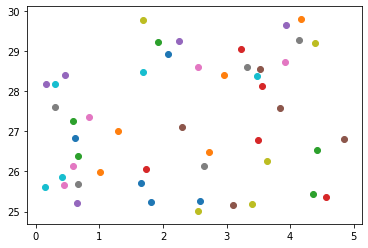

In [4]:
ICs = []
num_ics = 50
for i in range(0, num_ics):
    r = rd.uniform(30, 40)
    theta = rd.uniform(0, 0.5*3.14)
    ICs.append([np.random.uniform(0, 5), np.random.uniform(25, 30)])
    
for i in range(0, num_ics):
    plt.scatter(ICs[i][0],ICs[i][1])

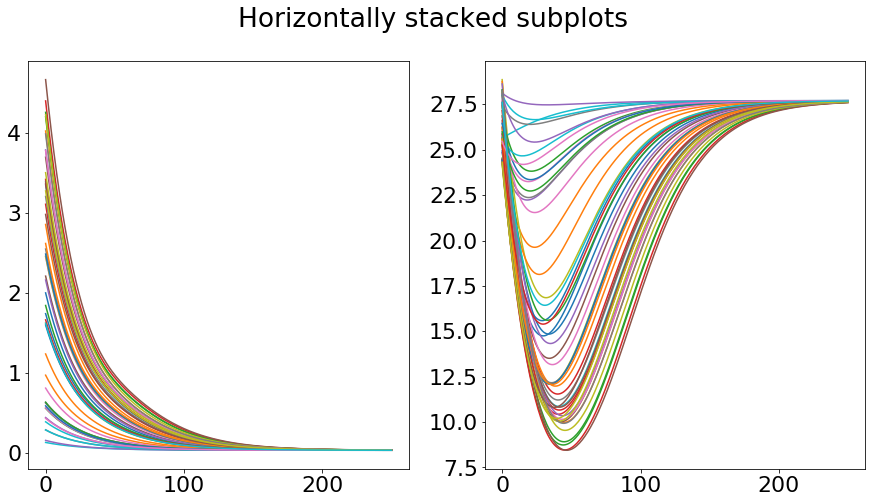

In [5]:
T = 250
matplotlib.rcParams.update({'font.size': 22})

t = np.linspace(0, T, T+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
fig.suptitle('Horizontally stacked subplots')
count = 0
for ic in ICs:
    x = np.array([ic[0], ic[1]])
    sol = []
    for i in range(0, T+1):
        y = discrete_toggle_switch(x)
        x = y
        sol.append(x)
    if not count:
        Xp_data = np.array(sol[0:-1]).T
        Xf_data = np.array(sol[1:]).T
    else:
        #print("exec")
        Xp_data = np.hstack([Xp_data, np.array(sol[0:-1]).T])
        Xf_data = np.hstack([Xf_data, np.array(sol[1:]).T])        
    ax1.plot(t, np.array(sol).T[0])
    ax2.plot(t, np.array(sol).T[1])
    count+=1

In [6]:
Xp=tf.compat.v1.placeholder(tf.compat.v1.double, shape = (2, Xp_data.shape[1]))

Xf=tf.compat.v1.placeholder(tf.compat.v1.double, shape = (2, Xf_data.shape[1]))

#n = tf.compat.v1.Variable(np.random.randn(), name = 'n', dtype = tf.double)
#n1 = tf.compat.v1.get_variable('n1',
#                   dtype=tf.double,
#                   shape=(),
#                   initializer=tf.random_uniform_initializer(minval=1., maxval=10.),
#                   constraint=lambda z: tf.clip_by_value(z, 1, 10))

V1 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=5,stddev=0.3,dtype=tf.double))
V2 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=5,stddev=0.3,dtype=tf.double))
b1 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))
b2 = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))

n = tf.Variable(tf.compat.v1.truncated_normal((1, ), mean=3,stddev=0.3,dtype=tf.double))

#n1 = tf.Variable(1.0, dtype = tf.double)

Kx = tf.Variable(tf.compat.v1.truncated_normal((4, 4), mean=0.0,stddev=0.1,dtype=tf.double));
#np.abs(Y - W*b)


#last_col = tf.constant(np.zeros(shape=(3, 1)), dtype=tf.dtypes.double)

#last_col = tf.concat([last_col, [[1.]]], axis=0)

#Kx = tf.concat([Kx, last_col], axis=1)  
#print(Kx)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


R2 = (1 - tf.divide(tf.math.reduce_sum(tf.math.square(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.math.reduce_mean(tf.concat([Xf, [Xf[0]**n1]], axis = 0), axis=0))), tf.math.reduce_sum(tf.math.square(tf.concat([Xf, [Xf[0]**n1]], axis = 0) - tf.matmul(Kx, tf.concat([Xf, [Xf[0]**n1]], axis = 0)))))) * 100

In [7]:
sess = tf.compat.v1.InteractiveSession();
sess.run(tf.compat.v1.global_variables_initializer());



/Users/dennisjoshy/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [8]:
def generalized_hill_function(X):
    return tf.concat([[V1/(1 + b1*X[0]**n)], [V2/(1 + b2*X[1]**n)]], axis = 0)

In [9]:
def generalized_hill_function_numpy(X):
    return np.vstack([[V1/(1 + b1*X[0]**coop)], [V2/(1 + b2*X[1]**coop)]])

In [10]:
cost = tf.reduce_sum(tf.pow(tf.concat([Xf, generalized_hill_function(Xf)], axis = 0) - tf.matmul(Kx, tf.concat([Xp, generalized_hill_function(Xp)], axis = 0)), 2))/Xp_data.shape[1]


In [11]:
training_epochs = 100000
learning_rate = 0.00050
error_threshold = 0.0000001
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-08, use_locking=False, name='Adam').minimize(cost)
init = tf.compat.v1.global_variables_initializer()
c = 100
epoch = 0
with tf.compat.v1.Session() as sesh:    
    sesh.run(init)    
    #print("Initial n1", sesh.run(n1))
    while epoch < training_epochs and c > error_threshold:
        c = sesh.run(cost, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)})
        if epoch % 5000 == 0:
            print("Epoch:", epoch, "{:.5f}".format(c))
            #print("Exponent", sesh.run(n1))
            #print("R2", sesh.run(R2, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))
        sesh.run(optimizer, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)})
        epoch+=1
    KxT_num = sesh.run(Kx)
    #sesh.close()
    print("coop", sesh.run(n))
    coop = sesh.run(n)
    print("V1", sesh.run(V1))
    V1 = sesh.run(V1)
    print("V2", sesh.run(V2))
    V2 = sesh.run(V2)
    print("b1", sesh.run(b1))
    b1 = sesh.run(b1)
    print("b2", sesh.run(b2))
    b2 = sesh.run(b2)
    #print("Exponent", sesh.run(n))
    print(sesh.run(cost, feed_dict = {Xp: np.array(Xp_data), Xf: np.array(Xf_data)}))

Epoch: 0 737.29908
Epoch: 5000 0.00068
Epoch: 10000 0.00010
Epoch: 15000 0.00008
Epoch: 20000 0.00006
Epoch: 25000 0.00005
Epoch: 30000 0.00004
Epoch: 35000 0.00003
Epoch: 40000 0.00003
Epoch: 45000 0.00002
Epoch: 50000 0.00002
Epoch: 55000 0.00002
Epoch: 60000 0.00002
Epoch: 65000 0.00002
Epoch: 70000 0.00001
Epoch: 75000 0.00001
Epoch: 80000 0.00001
Epoch: 85000 0.00001
Epoch: 90000 0.00001
Epoch: 95000 0.00001
coop [1.98629434]
V1 [1.09030124]
V2 [4.92712937]
b1 [1.97647073]
b2 [2.75644971]
9.355263113655522e-06


In [12]:
KxT_num

array([[ 9.63993283e-01, -6.95802838e-06, -6.89850140e-06,
         5.38557794e-01],
       [ 7.39669753e-04,  9.63825694e-01,  9.21707962e-01,
        -1.96609373e-01],
       [ 2.52282940e-03, -1.24877991e-04,  1.00186219e+00,
         7.89542250e-01],
       [-9.31011233e-06,  5.66018086e-05, -6.22547771e-04,
         1.00275789e+00]])

In [13]:
np.linalg.eig(KxT_num)

(array([0.96254208+0.j       , 0.97601371+0.0274094j,
        0.97601371-0.0274094j, 1.01786955+0.j       ]),
 array([[-0.44461246+0.j        , -0.01842736+0.01642833j,
         -0.01842736-0.01642833j,  0.01294435+0.j        ],
        [-0.89572033+0.j        ,  0.99917254+0.j        ,
          0.99917254-0.j        ,  0.99818519+0.j        ],
        [ 0.00185731+0.j        ,  0.01296385+0.02957807j,
          0.01296385-0.02957807j,  0.0587968 +0.j        ],
        [ 0.00118651+0.j        , -0.00123432-0.00057079j,
         -0.00123432+0.00057079j,  0.00130858+0.j        ]]))

## Discrete model

In [14]:
KxT_num

array([[ 9.63993283e-01, -6.95802838e-06, -6.89850140e-06,
         5.38557794e-01],
       [ 7.39669753e-04,  9.63825694e-01,  9.21707962e-01,
        -1.96609373e-01],
       [ 2.52282940e-03, -1.24877991e-04,  1.00186219e+00,
         7.89542250e-01],
       [-9.31011233e-06,  5.66018086e-05, -6.22547771e-04,
         1.00275789e+00]])

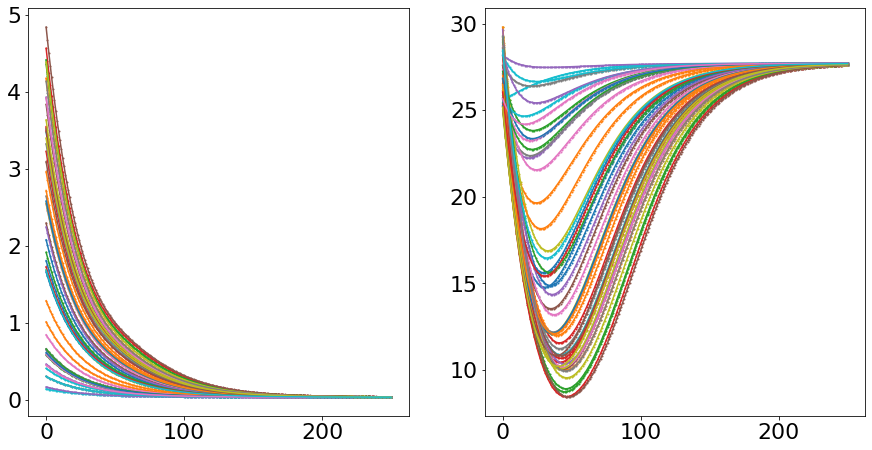

In [16]:
Xp_final_learned = []
Xf_final_learned = []
Xp_final_actual = []
Xf_final_actual = []
#t = np.array([i for i in range(0, N+1)])
x_learned = np.zeros(2)
x_actual = np.zeros(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
#fig.suptitle('Horizontally stacked subplots')
for ic in ICs:
    #ic_s = scaler.transform(np.array([ic]))
    x_learned = np.array(ic)
    x_actual[0] = ic[0]
    x_actual[1] = ic[1]
    X_learned = []
    #print("x_actual", x_actual)
    #print("x_learned", x_learned)
    X_actual = []
    X_learned.append([x_learned[0], x_learned[1]]) ## ICs
    X_actual.append(np.array([x_actual[0], x_actual[1]])) 
    for k in range(0, T):
        obs = generalized_hill_function_numpy(x_learned).T[0]
        y_learned =  np.matmul(KxT_num, np.vstack([x_learned[0], x_learned[1], obs[0], obs[1]]))[0:2]
        x_learned = y_learned#np.array([[y_learned[0], y_learned[1]]])
        X_learned.append([x_learned[0], x_learned[1]]) 
        y_actual = discrete_toggle_switch(x_actual)
        x_actual = y_actual
        X_actual.append(x_actual)
        #if k % 10 == 0:
            #print(y_learned)
    #print('Plotting')
    ax1.scatter(t, np.array(X_actual).T[0], s = 1)
    ax1.plot(t, np.array(X_learned).T[0])
    ax2.scatter(t, np.array(X_actual).T[1], s = 1)
    ax2.plot(t, np.array(X_learned).T[1])